# K-Nearest Neighbor (KNN)
---
**Collaborators:** Amy Zhang (lead), ChatGPT, Perplexity AI, Gemini AI  
**Date:** June 2025

---
## Overview
This notebook implements K-Nearest Neighbor (KNN) classification on daily weather records from the **OSLO weather station (1960–2022)** using six meteorological features:

- Precipitation
- Global Radiation
- Sunshine Duration
- Temperature Min / Mean / Max

---
## Model Overview 📍

K-Nearest Neighbor (KNN) classifies data based on the *k* closest points in feature space.

**Key points:**

- Instance-based, non-parametric — no explicit training, just stores data.
- **Hyperparameter:**  
  - *k*: number of neighbors  
  - Small *k*: complex but risks overfitting  
  - Large *k*: smoother but risks underfitting
- Sensitive to feature scaling and dimensionality.

> ❗ **Scaling is critical** — features with different units must be normalized **after** train/test split.

---

## Objectives ✅

- Preprocess OSLO weather data
- Select optimal *k* with cross-validation
- Train and evaluate KNN model with accuracy, confusion matrix, learning curves

# 📦 1. Import Libraries & Datasets

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data preprocessing and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# KNN model and validation
from sklearn.model_selection import cross_val_score  # For performing cross-validation
from sklearn.neighbors import KNeighborsClassifier

# Pipeline utility to chain preprocessing (e.g., scaling) and model steps,
# ensuring transformations happen correctly during cross-validation and predictions
from sklearn.pipeline import make_pipeline

# For generating learning curves to evaluate model performance across different training sizes
from sklearn.model_selection import learning_curve

# Metrics and evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🔒 Set seeds for reproducibility
np.random.seed(42)


In [ ]:
weather_df = pd.read_csv('Dataset-weather-prediction-dataset-processed.csv')

In [ ]:
pleasant_weather = pd.read_csv('Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv')

# 🧹2. Data Selection and Cleaning

- Select relevant features
- Extract X and y
- Handle missing data (drop NaNs)

*Note: Scaling is **not** performed here yet — it will be done after splitting the dataset to avoid data leakage.*

In [ ]:
# Select relevant OSLO features
oslo_features = [
    'OSLO_global_radiation',
    'OSLO_precipitation',
    'OSLO_sunshine',
    'OSLO_temp_max',
    'OSLO_temp_mean',
    'OSLO_temp_min'
]

# Extract features and target
X = weather_df[oslo_features].copy()
y = pleasant_weather['OSLO_pleasant_weather'].copy()

# Drop rows with missing values
X.dropna(inplace=True)
y = y.loc[X.index]  # Align target to cleaned features


# 📊 3. Train/Test Split
- Split data into training and testing sets

In [ ]:
# 1. Split *unscaled* data first with stratification to keep class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### 📝 Learning Note: Pipelines vs. Manual Scaling in Cross-Validation

To handle scaling correctly during cross-validation, we wrap the KNN model inside a `Pipeline` with a `StandardScaler`. This ensures that **each fold in the cross-validation process applies scaling properly without leaking information from validation data into training**.

Here’s how it works:

* The scaler is **fitted only on the training fold** within each split,
* Then the training fold is scaled,
* Then the validation fold is transformed using those same training fold parameters.

Because of this, we **do not manually scale `X_train` or `X_test` here** — instead, we pass the raw, unscaled data into the pipeline and let it handle scaling internally during cross-validation and final testing.

# 🔄 4. K-Fold Cross-Validation

To select the best number of neighbors (**K**) for our KNN model, we use **5-Fold Cross-Validation** on the training set.

* The training data is split into **5 equal parts**.
* Each part takes a turn as the **validation set**, while the model trains on the other four.
* This process gives us a **more robust estimate** of the model’s generalization performance than a single train/test split.

### 🎯 Goal: Choose K that balances bias and variance

The main objective is to find the **smallest K** that achieves the **highest (or near-highest) cross-validated accuracy**, in order to strike a balance between:

* **Bias** → Too much K leads to over-smoothing, where the model underfits by averaging over many points and missing important patterns. (*Note: It can be helpful to think of bias as 'bias against the dataset': not being as attentive to its specificities.*)
* **Variance** → Too little K causes the model to memorize noise, overfitting to individual neighbors and producing unstable predictions.

In short:

* **High K → High bias, low variance**
* **Low K → Low bias, high variance**

#### 🦾 Cross-Validation Graph (Best K: 8)

Best K: 8
Highest Cross-Validated Accuracy: 0.9630


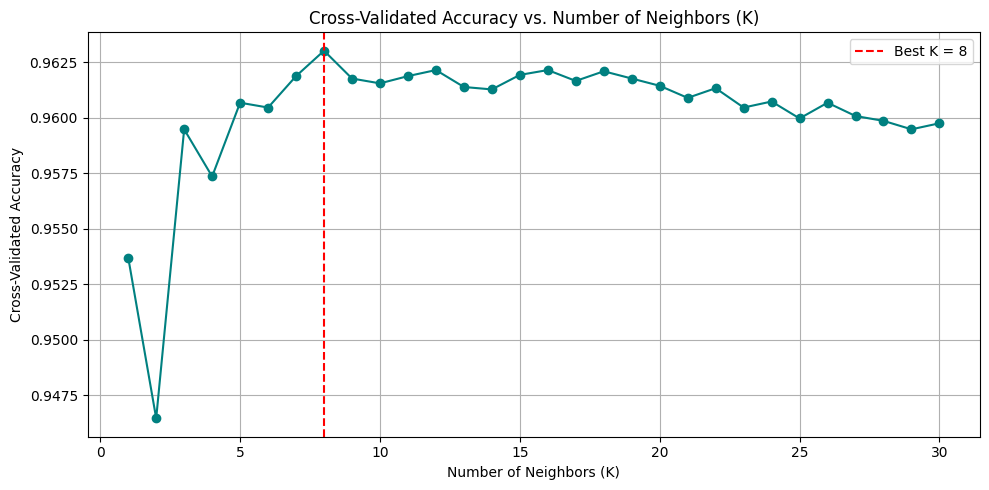

In [ ]:
# 2. Define range of K values to test
k_range = range(1, 31)
cv_scores = []

# 3. Loop through K values with pipeline including scaling + KNN
for k in k_range:
    # Create pipeline: scaling + KNN with current k
    pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))

    # 5-fold CV on training data only
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')

    # Store mean CV accuracy
    cv_scores.append(scores.mean())

# 4. Best K & best CV score
best_k = k_range[np.argmax(cv_scores)]
best_score = max(cv_scores)
print(f"Best K: {best_k}")
print(f"Highest Cross-Validated Accuracy: {best_score:.4f}")

# 5. Plot CV accuracy vs K
plt.figure(figsize=(10, 5))
plt.plot(k_range, cv_scores, marker='o', color='teal')
plt.title("Cross-Validated Accuracy vs. Number of Neighbors (K)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Cross-Validated Accuracy")
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best K = {best_k}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🛠️ 5. Model Building and Training




### 🎯 Final KNN Accuracy with K=8: 0.9612

With an optimal K value of 8, the K-Nearest Neighbors model achieved a strong prediction accuracy of approximately 96% on previously unseen test data.



In [ ]:
# 6. Fit final model with best K on full training data
final_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=best_k))
final_pipe.fit(X_train, y_train)

# 7. Evaluate on test set
test_accuracy = final_pipe.score(X_test, y_test)
print(f"Test Set Accuracy with K={best_k}: {test_accuracy:.4f}")

Test Set Accuracy with K=8: 0.9612


###🧮 Final Report

| Metric        | Unpleasant (3,874 samples)                                                  | Pleasant (716 samples)                                                  |
| ------------- | --------------------------------------------------------------------------- | ----------------------------------------------------------------------- |
| **Precision** | 0.98 → Of all days predicted as *Unpleasant*, 98% were actually unpleasant. | 0.85 → Of all days predicted as *Pleasant*, 85% were actually pleasant. |
| **Recall**    | 0.97 → Of all *unpleasant* days, KNN correctly identified 97%.              | 0.91 → Of all *pleasant* days, KNN correctly identified 91%.            |
| **F1-score**  | 0.98 → Strong balance between precision & recall.                           | 0.88 → Slightly lower due to lower precision, but still strong overall. |
| **Support**   | 3,874 → Number of actual unpleasant days in the test set.                   | 716 → Number of actual pleasant days in the test set.                   |


#### 📝 Learning Note: How Class Imbalance Affects Errors in KNN (and Most Classifiers)
Class imbalance can distort the decision boundary in KNN because the algorithm relies on the local distribution of neighbors — not an internal model or learned patterns.
To put it more bluntly: KNN doesn’t try to “understand” the data — it simply reflects the raw distribution it observes.
When that distribution is skewed, the predictions are skewed too.

**KNN at a glance**:
- Non-inductive, instance-based algorithm
- Does not learn a general model or pattern from the training data (unlike neural networks)
- Stores the training data and makes decisions literally — based on proximity at prediction time


In [ ]:
from sklearn.metrics import classification_report

# 8. Generate predictions on test set
y_pred = final_pipe.predict(X_test)

# 9. Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Unpleasant', 'Pleasant']))


              precision    recall  f1-score   support

  Unpleasant       0.98      0.97      0.98      3874
    Pleasant       0.85      0.91      0.88       716

    accuracy                           0.96      4590
   macro avg       0.92      0.94      0.93      4590
weighted avg       0.96      0.96      0.96      4590



# 🧐 6. Model Evaluation: Confusion Matrix insights

- 97.0% of predictions labeled unpleasant were correct — the model is highly precise in identifying unpleasant weather.

- 91.5% of predictions labeled pleasant were correct — still strong, though slightly lower.

- This ***performance asymmetry*** is partly due to *class imbalance*, with unpleasant weather days occurring more frequently than pleasant ones in the dataset.

As a result, the model is slightly biased toward the majority class, but still performs well across both.

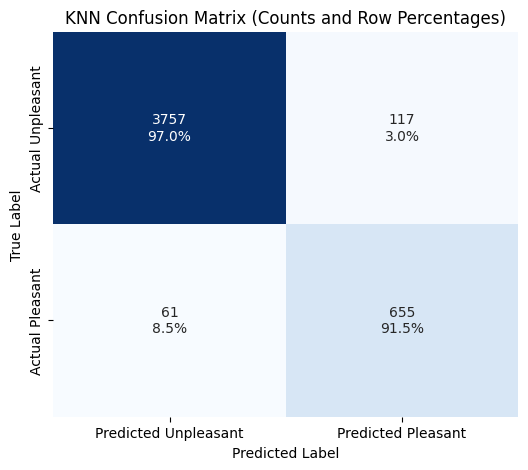

In [ ]:
# Compute raw confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate percentages
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Create annotations combining counts and percentages
annotations = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annotations[i, j] = f"{cm[i, j]}\n{cm_percent[i, j]:.1f}%"

# Plot with seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', cbar=False,
            xticklabels=['Predicted Unpleasant', 'Predicted Pleasant'],
            yticklabels=['Actual Unpleasant', 'Actual Pleasant'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('KNN Confusion Matrix (Counts and Row Percentages)')
plt.show()
